<h2><b>GDP Forecasting</b></h2>

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
import sklearn 
from scipy import stats,signal
from sklearn.linear_model import LinearRegression
from datetime import datetime
import datetime as dt
from scipy import stats,signal
from statsmodels.tsa.exponential_smoothing.ets import ETSModel 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR # da vedere se tenere questo
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

<h3><b>Data Acquisition</b></h3>

In [4]:
# Load the data
GDP_df = pd.read_csv('dataset_GDP.csv')
pd.options.display.float_format = '{:,.0f}'.format
GDP_df.head(5)


,CountryID,Country,IndicatorName,1970,1971,1972,1973,1974,1975,1976,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,4,Afghanistan,Final consumption expenditure,"3,068,715,393","2,957,075,039","2,886,787,577","3,100,415,960","3,328,662,493","3,514,641,945","3,587,321,657",...,"11,534,938,804","15,376,167,617","18,494,920,234","18,565,722,183","19,126,816,049","19,309,303,808","18,130,944,558","21,545,080,078","24,944,282,107","22,102,587,424"
1,4,Afghanistan,Household consumption expenditure (including N...,"2,734,160,598","2,614,419,519","2,529,175,456","2,724,907,645","2,941,860,483","3,012,107,387","3,032,225,144",...,"8,263,217,942","11,708,134,276","14,636,896,994","14,608,488,737","14,977,655,054","14,949,016,550","14,048,999,937","17,676,628,564","19,988,863,832","18,354,134,113"
2,4,Afghanistan,General government final consumption expenditure,"328,878,718","337,533,422","353,007,752","370,416,351","381,054,920","498,079,705","551,272,377",...,"3,284,910,216","3,673,732,699","3,855,382,462","3,956,029,969","4,149,160,995","4,363,227,630","4,084,495,507","3,854,647,774","4,947,606,740","3,730,519,634"
3,4,Afghanistan,Gross capital formation,"1,654,636,926","1,764,946,054","1,615,794,959","1,566,078,673","1,914,096,976","2,257,142,607","3,214,192,574",...,"3,424,102,198","3,502,218,363","3,362,393,925","2,670,612,302","2,564,175,617","2,570,763,930","2,781,502,854","3,190,770,611","2,640,315,151","3,441,860,942"
4,4,Afghanistan,Gross fixed capital formation (including Acqui...,"1,653,901,160","1,764,161,237","1,543,641,082","1,543,641,082","1,984,681,171","2,293,409,608","3,418,062,396",...,"3,318,639,615","3,518,975,222","3,286,278,866","2,474,054,022","2,564,175,617","2,547,500,177","2,756,332,051","3,161,896,199","2,616,422,006","3,410,714,324"


In [5]:
# Choosing 5 countries
selected_countries = ['Nigeria', 'Germany', 'Japan', 'United States', 'Australia']
GDP5_df = GDP_df[GDP_df['Country'].isin(selected_countries)]
GDP5_df = GDP5_df.drop(columns=['CountryID'])
GDP5_df.reset_index(drop=True, inplace=True)
GDP5_df.head(17)

,Country,IndicatorName,1970,1971,1972,1973,1974,1975,1976,1977,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Australia,Final consumption expenditure,"220,459,532,962","228,773,153,116","238,627,451,948","251,448,690,614","266,077,582,168","272,888,662,820","284,167,783,594","290,491,690,279",...,"876,934,729,463","889,277,429,445","909,024,885,889","930,515,230,588","959,474,376,775","987,671,459,104","1,017,838,825,515","1,043,918,104,320","1,038,439,016,303","1,063,104,267,271"
1,Australia,Household consumption expenditure (including N...,"167,168,382,177","173,196,881,423","181,283,629,038","192,665,591,225","202,062,067,763","203,588,643,994","214,434,611,507","218,677,902,683",...,"662,935,359,911","674,663,845,538","691,116,144,448","707,333,585,477","726,705,038,181","743,158,057,515","764,242,675,994","777,698,735,855","754,609,900,729","762,813,356,861"
2,Australia,General government final consumption expenditure,"53,292,046,403","55,575,919,542","57,346,369,394","58,793,419,941","64,018,003,831","69,285,612,018","69,729,479,357","71,807,552,938",...,"213,993,535,057","214,618,821,518","217,920,936,370","223,193,564,059","232,769,338,594","244,490,591,443","253,565,132,909","266,159,061,931","283,680,707,188","300,093,759,706"
3,Australia,Gross capital formation,"72,836,652,373","71,694,291,413","71,185,683,013","77,085,975,159","61,629,991,815","60,662,337,441","65,066,166,244","63,953,936,456",...,"342,176,250,701","348,196,638,301","338,459,823,588","328,594,117,373","316,549,532,278","316,819,054,129","333,602,625,189","325,671,607,958","311,668,358,646","330,183,231,122"
4,Australia,Gross fixed capital formation (including Acqui...,"56,682,782,088","58,273,754,009","60,056,131,870","62,619,244,482","58,605,476,332","60,618,116,977","62,976,151,797","65,391,032,742",...,"336,996,060,228","346,739,773,838","340,189,517,210","327,630,121,497","315,694,594,013","315,571,547,338","331,315,765,180","326,469,453,152","317,342,412,059","326,140,609,114"
5,Australia,Changes in inventories,"12,447,777,351","10,348,552,035","8,589,334,645","11,155,146,059","2,360,721,980","72,001,756","1,645,416,805","-1,063,210,356",...,"4,191,713,518","1,336,916,692","-1,115,662,054","946,222,142","854,938,265","1,156,500,727","1,964,989,097","-408,259,659","-4,160,738,819","3,310,825,628"
6,Australia,Exports of goods and services,"26,159,371,989","28,117,843,227","28,684,232,409","26,950,685,271","29,586,842,331","30,742,928,893","32,939,143,738","33,680,927,101",...,"188,605,266,980","198,607,979,643","210,431,062,477","224,806,392,862","240,182,810,300","253,405,550,353","263,845,291,706","274,343,303,551","269,246,383,613","244,666,141,958"
7,Australia,Imports of goods and services,"21,520,059,659","19,803,621,423","20,054,054,928","26,137,651,653","26,810,018,972","25,495,422,464","27,922,259,468","26,614,121,130",...,"271,941,366,092","272,686,208,437","266,324,910,376","268,892,391,985","268,573,071,326","281,536,772,487","302,012,761,228","302,650,684,971","280,410,898,075","271,726,093,738"
8,Australia,Gross Domestic Product (GDP),"314,442,893,932","326,745,546,144","335,285,770,129","349,043,759,552","353,755,559,858","362,909,679,038","375,965,091,877","379,337,047,012",...,"1,129,408,358,863","1,158,602,409,573","1,187,951,137,123","1,213,998,717,159","1,247,634,399,291","1,276,337,608,825","1,313,980,452,319","1,342,374,995,624","1,338,551,384,112","1,357,719,625,710"
9,Australia,"Agriculture, hunting, forestry, fishing (ISIC ...","11,162,293,505","12,379,284,473","10,866,925,497","11,457,661,513","12,663,435,974","13,711,035,181","14,077,436,874","13,616,209,391",...,"31,666,653,353","31,405,398,625","31,749,222,749","32,229,802,434","29,942,372,147","32,758,762,625","31,846,628,833","26,576,379,130","23,900,517,208","29,168,639,163"


In [6]:
# Filter the dataset based on certain variables
indicator_values = ['Gross Domestic Product (GDP)', 'Exports of goods and services', 'Imports of goods and services','Manufacturing (ISIC D)','Gross capital formation']
GDP_final = GDP5_df[GDP5_df['IndicatorName'].isin(indicator_values)]
GDP_final.head()

,Country,IndicatorName,1970,1971,1972,1973,1974,1975,1976,1977,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3,Australia,Gross capital formation,"72,836,652,373","71,694,291,413","71,185,683,013","77,085,975,159","61,629,991,815","60,662,337,441","65,066,166,244","63,953,936,456",...,"342,176,250,701","348,196,638,301","338,459,823,588","328,594,117,373","316,549,532,278","316,819,054,129","333,602,625,189","325,671,607,958","311,668,358,646","330,183,231,122"
6,Australia,Exports of goods and services,"26,159,371,989","28,117,843,227","28,684,232,409","26,950,685,271","29,586,842,331","30,742,928,893","32,939,143,738","33,680,927,101",...,"188,605,266,980","198,607,979,643","210,431,062,477","224,806,392,862","240,182,810,300","253,405,550,353","263,845,291,706","274,343,303,551","269,246,383,613","244,666,141,958"
7,Australia,Imports of goods and services,"21,520,059,659","19,803,621,423","20,054,054,928","26,137,651,653","26,810,018,972","25,495,422,464","27,922,259,468","26,614,121,130",...,"271,941,366,092","272,686,208,437","266,324,910,376","268,892,391,985","268,573,071,326","281,536,772,487","302,012,761,228","302,650,684,971","280,410,898,075","271,726,093,738"
8,Australia,Gross Domestic Product (GDP),"314,442,893,932","326,745,546,144","335,285,770,129","349,043,759,552","353,755,559,858","362,909,679,038","375,965,091,877","379,337,047,012",...,"1,129,408,358,863","1,158,602,409,573","1,187,951,137,123","1,213,998,717,159","1,247,634,399,291","1,276,337,608,825","1,313,980,452,319","1,342,374,995,624","1,338,551,384,112","1,357,719,625,710"
11,Australia,Manufacturing (ISIC D),"45,450,575,115","46,381,103,624","48,422,640,983","51,694,726,118","49,568,808,340","49,040,099,497","50,251,555,765","50,034,287,372",...,"82,059,513,859","79,378,973,478","78,639,722,818","77,436,338,442","75,789,000,074","75,373,970,359","77,043,506,426","73,510,036,257","72,502,242,074","73,666,127,773"


In [31]:
GDP_final.info()

#checking null value 
GDP_final.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 3 to 79
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country        25 non-null     object 
 1   IndicatorName  25 non-null     object 
 2   1970           25 non-null     float64
 3   1971           25 non-null     float64
 4   1972           25 non-null     float64
 5   1973           25 non-null     float64
 6   1974           25 non-null     float64
 7   1975           25 non-null     float64
 8   1976           25 non-null     float64
 9   1977           25 non-null     float64
 10  1978           25 non-null     float64
 11  1979           25 non-null     float64
 12  1980           25 non-null     float64
 13  1981           25 non-null     float64
 14  1982           25 non-null     float64
 15  1983           25 non-null     float64
 16  1984           25 non-null     float64
 17  1985           25 non-null     float64
 18  1986        

Country          0
IndicatorName    0
1970             0
1971             0
1972             0
1973             0
1974             0
1975             0
1976             0
1977             0
1978             0
1979             0
1980             0
1981             0
1982             0
1983             0
1984             0
1985             0
1986             0
1987             0
1988             0
1989             0
1990             0
1991             0
1992             0
1993             0
1994             0
1995             0
1996             0
1997             0
1998             0
1999             0
2000             0
2001             0
2002             0
2003             0
2004             0
2005             0
2006             0
2007             0
2008             0
2009             0
2010             0
2011             0
2012             0
2013             0
2014             0
2015             0
2016             0
2017             0
2018             0
2019             0
2020        

In [9]:
# Exporting new dataset in Excel
New_file = 'GDP.xlsx'

GDP_final.to_excel(New_file, index=False)

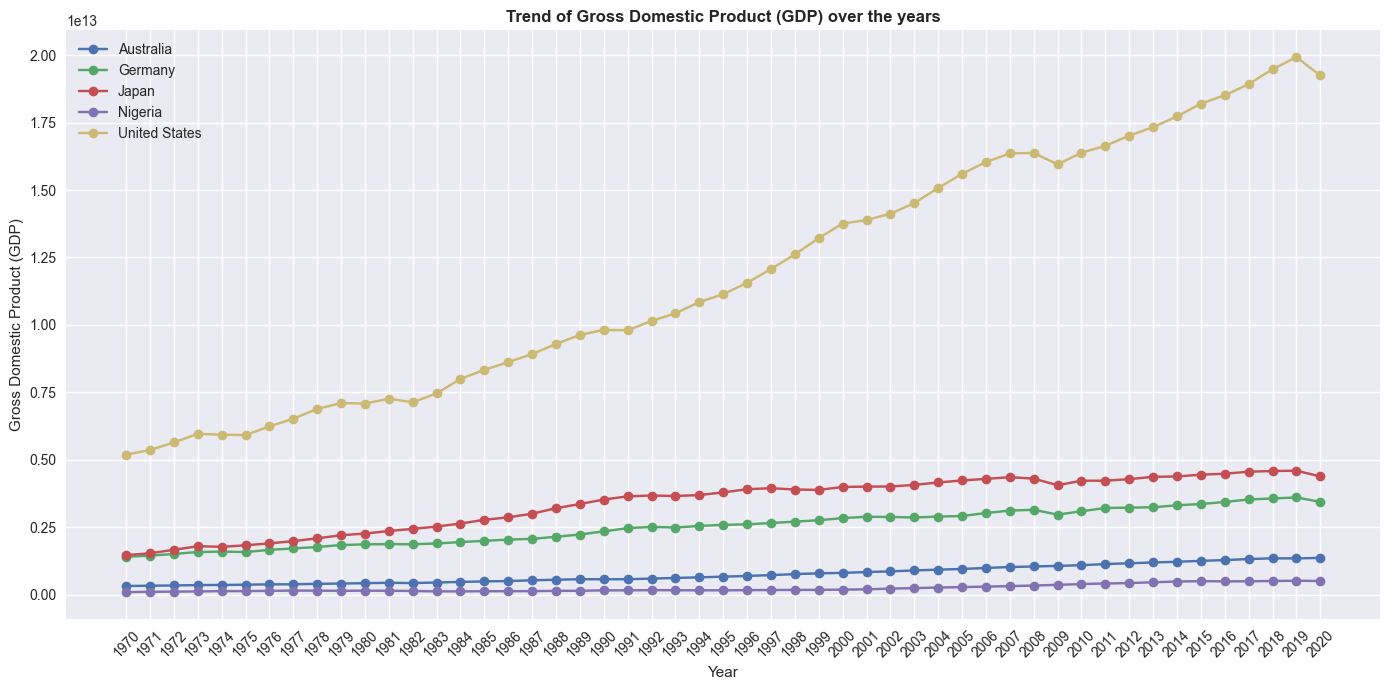

In [30]:
# Function to plot the economic indicator trends for all countries
def plot_economic_indicator(indicator):
    # Filter the dataframe for the selected indicator
    GDP_final['IndicatorName'] = GDP_final['IndicatorName'].str.strip()  # Strip leading/trailing spaces
    df_filtered = GDP_final[GDP_final['IndicatorName'] == indicator]
    
    plt.figure(figsize=(14, 7))
    
    # Iterate over each country in the filtered dataframe
    for country in df_filtered['Country'].unique():
        country_data = df_filtered[df_filtered['Country'] == country]
        years = country_data.columns[2:]  # Year columns start from the third column
        values = country_data.iloc[0, 2:].values.astype(float)  # Convert values to float
        
        plt.plot(years, values, marker='o', label=country)
    
    plt.title(f'Trend of {indicator} over the years', fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel(indicator)
    plt.legend()
    plt.grid(True)
    
    # Rotate the x-axis labels and set them
    plt.xticks(rotation=45)
    
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Example: plot the graph for "Gross Domestic Product (GDP)"
plot_economic_indicator("Gross Domestic Product (GDP)")

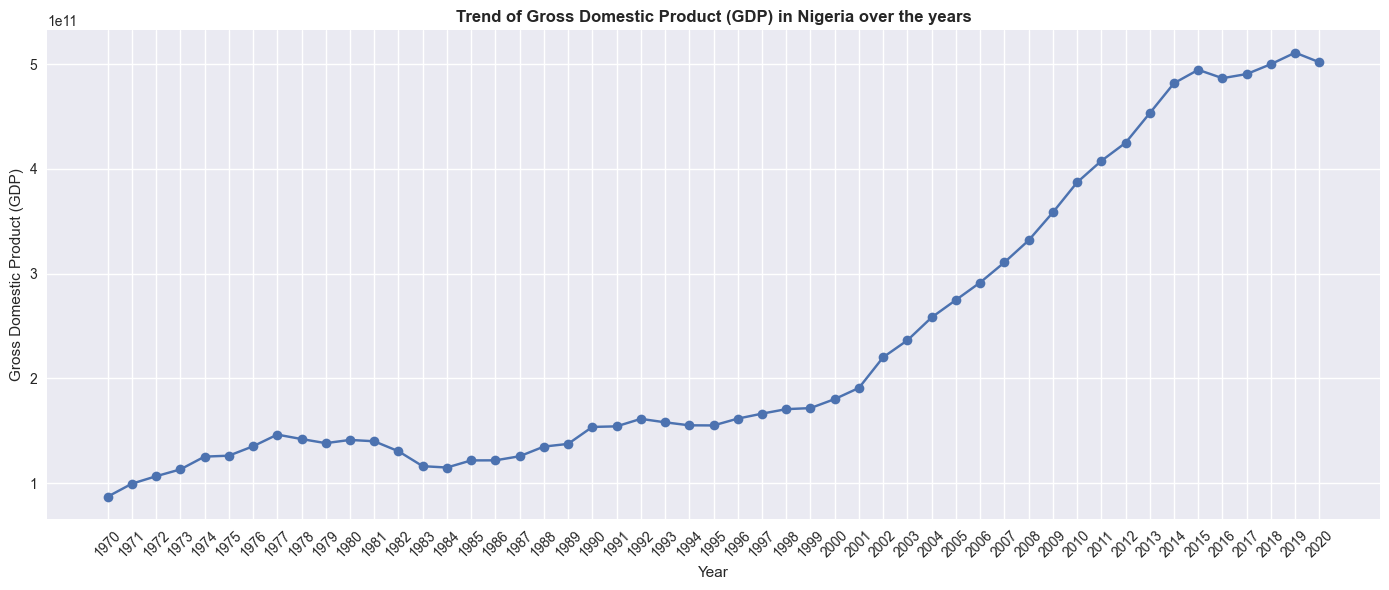

In [29]:
# Function to plot the economic indicator trends for a specific country
def plot_economic_indicator_for_country(indicator, country):
    # Filter the dataframe for the selected indicator and country
    GDP_final['IndicatorName'] = GDP_final['IndicatorName'].str.strip()  # Strip leading/trailing spaces
    df_filtered = GDP_final[(GDP_final['IndicatorName'] == indicator) & (GDP_final['Country'] == country)]

    years = df_filtered.columns[2:]  # Year columns start from the third column
    values = df_filtered.iloc[0, 2:].values.astype(float)  # Convert values to float
    
    plt.figure(figsize=(14, 6))
    
    plt.plot(years, values, marker='o')
    
    plt.title(f'Trend of {indicator} in {country} over the years', fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel(indicator)
    plt.grid(True)
    
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example: plot the GDP trend for a specific country (e.g., United States)
plot_economic_indicator_for_country("Gross Domestic Product (GDP)", "Nigeria")

<h2><b>Australia</b></h2>

In [46]:
GDP_Australia = GDP_final[GDP_final['Country'] == 'Australia']
GDP_Australia.reset_index(drop=True, inplace=True)
GDP_Australia

,Country,IndicatorName,1970,1971,1972,1973,1974,1975,1976,1977,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Australia,Gross capital formation,"72,836,652,373","71,694,291,413","71,185,683,013","77,085,975,159","61,629,991,815","60,662,337,441","65,066,166,244","63,953,936,456",...,"342,176,250,701","348,196,638,301","338,459,823,588","328,594,117,373","316,549,532,278","316,819,054,129","333,602,625,189","325,671,607,958","311,668,358,646","330,183,231,122"
1,Australia,Exports of goods and services,"26,159,371,989","28,117,843,227","28,684,232,409","26,950,685,271","29,586,842,331","30,742,928,893","32,939,143,738","33,680,927,101",...,"188,605,266,980","198,607,979,643","210,431,062,477","224,806,392,862","240,182,810,300","253,405,550,353","263,845,291,706","274,343,303,551","269,246,383,613","244,666,141,958"
2,Australia,Imports of goods and services,"21,520,059,659","19,803,621,423","20,054,054,928","26,137,651,653","26,810,018,972","25,495,422,464","27,922,259,468","26,614,121,130",...,"271,941,366,092","272,686,208,437","266,324,910,376","268,892,391,985","268,573,071,326","281,536,772,487","302,012,761,228","302,650,684,971","280,410,898,075","271,726,093,738"
3,Australia,Gross Domestic Product (GDP),"314,442,893,932","326,745,546,144","335,285,770,129","349,043,759,552","353,755,559,858","362,909,679,038","375,965,091,877","379,337,047,012",...,"1,129,408,358,863","1,158,602,409,573","1,187,951,137,123","1,213,998,717,159","1,247,634,399,291","1,276,337,608,825","1,313,980,452,319","1,342,374,995,624","1,338,551,384,112","1,357,719,625,710"
4,Australia,Manufacturing (ISIC D),"45,450,575,115","46,381,103,624","48,422,640,983","51,694,726,118","49,568,808,340","49,040,099,497","50,251,555,765","50,034,287,372",...,"82,059,513,859","79,378,973,478","78,639,722,818","77,436,338,442","75,789,000,074","75,373,970,359","77,043,506,426","73,510,036,257","72,502,242,074","73,666,127,773"


In [47]:
# Exporting new dataset in Excel
New_file = 'GDP_Australia.xlsx'

GDP_Australia.to_excel(New_file, index=False)

In [48]:
# Melt the DataFrame to have years as rows and indicators as columns
df_melted = GDP_Australia.melt(id_vars=['IndicatorName'], var_name='Year', value_name='Value')

# Pivot the DataFrame to get the desired format
Australia_df = df_melted.pivot(index='Year', columns='IndicatorName', values='Value')

# Reset the index to have 'Year' as a column
Australia_df.reset_index(inplace=True)

Australia_df.head()

IndicatorName,Year,Exports of goods and services,Gross Domestic Product (GDP),Gross capital formation,Imports of goods and services,Manufacturing (ISIC D)
0,1970,"26,159,371,989","314,442,893,932","72,836,652,373","21,520,059,659","45,450,575,115"
1,1971,"28,117,843,227","326,745,546,144","71,694,291,413","19,803,621,423","46,381,103,624"
2,1972,"28,684,232,409","335,285,770,129","71,185,683,013","20,054,054,928","48,422,640,983"
3,1973,"26,950,685,271","349,043,759,552","77,085,975,159","26,137,651,653","51,694,726,118"
4,1974,"29,586,842,331","353,755,559,858","61,629,991,815","26,810,018,972","49,568,808,340"


In [39]:
Australia_df.describe().T

,count,mean,std,min,25%,50%,75%,max
IndicatorName,,,,,,,,
Exports of goods and services,51,"115,255,445,612","77,631,875,972","26,159,371,989","39,656,857,412","101,158,156,878","168,741,730,303","274,343,303,551"
Gross Domestic Product (GDP),51,"745,289,970,995","333,760,314,650","314,442,893,932","439,115,521,369","661,847,766,422","1,029,343,785,661","1,357,719,625,710"
Gross capital formation,51,"176,434,743,496","100,867,977,931","60,662,337,441","88,937,956,005","135,239,055,643","286,870,290,588","348,196,638,301"
Imports of goods and services,51,"118,967,114,761","98,199,740,997","19,803,621,423","34,638,398,127","75,573,512,609","210,368,449,815","302,650,684,971"
Manufacturing (ISIC D),51,"66,654,904,673","12,164,823,233","45,450,575,115","55,551,761,018","67,818,007,974","77,462,908,415","85,457,779,858"


<h3><b>Features analysis</b></h3>

In this section we are gonna analyze the single features in search of informations, patterns and characteristics.

In [53]:
Australia_df = Australia_df.drop(51)

<h5><b>Exports of goods and services</b></h5>

Text(0.5, 1.0, 'Exports through the years')

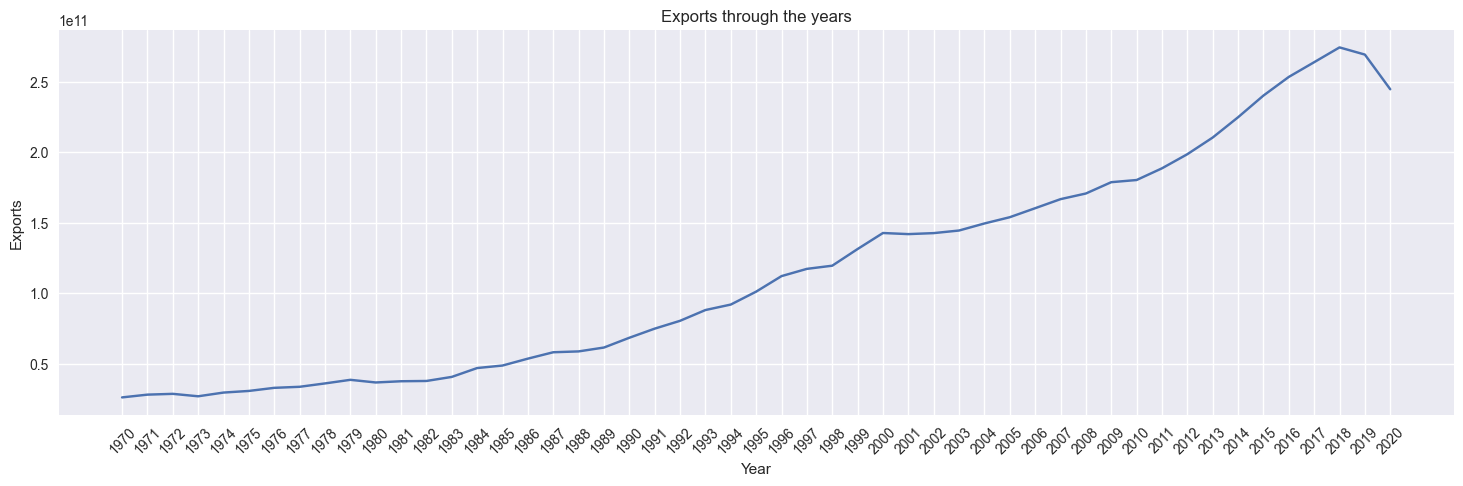

In [61]:
plt.figure(figsize=(18,5))
sns.lineplot(data=Australia_df, x="Year",y="Exports of goods and services")
plt.ylabel("Exports")
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.title("Exports through the years")

Thanks to the graph, we can observe that in general the values of the exports are in continuous increase during the years, made exception for the year 2000 where there is a sudden stop and the years from 2018 to 2020 where we notice a drastic descent cause coronavirus and fluctuations in raw material prices.

<h5><b>Gross Domestic Product (GDP)</b></h5>

Text(0.5, 1.0, 'GDP through the years')

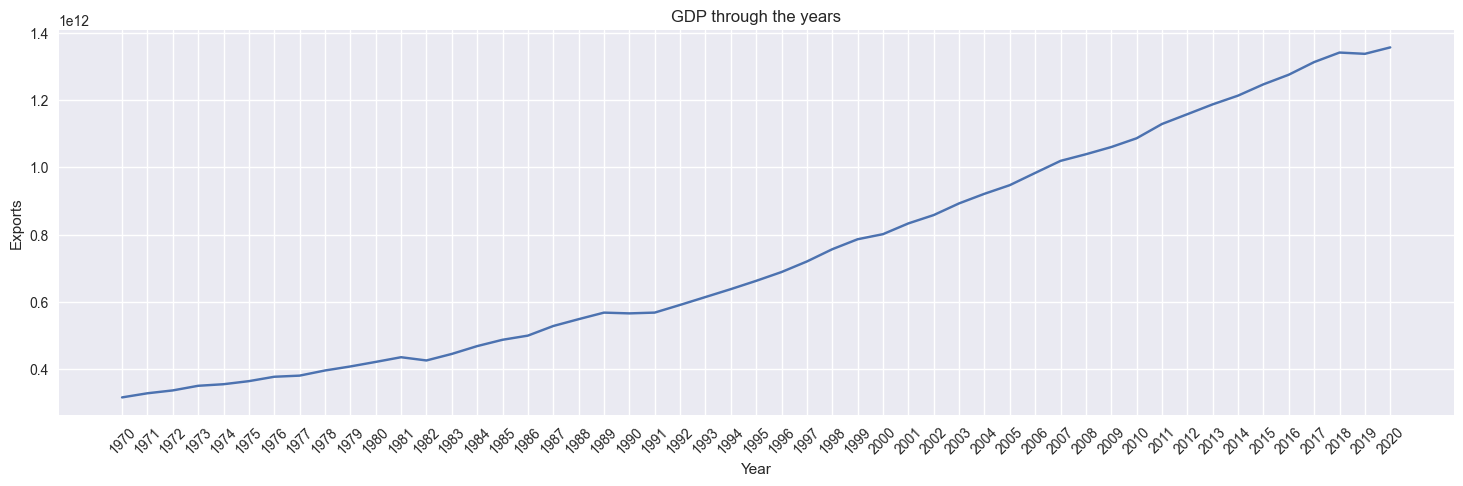

In [64]:
plt.figure(figsize=(18,5))
sns.lineplot(data=Australia_df, x="Year",y="Gross Domestic Product (GDP)")
plt.ylabel("Exports")
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.title("GDP through the years")

In the case of GDP we have a more linear situation where growth can be observed even between 2019 and 2020.

<h5><b>Gross capital formation</b></h5>

Text(0.5, 1.0, 'Gross capital formation through the years')

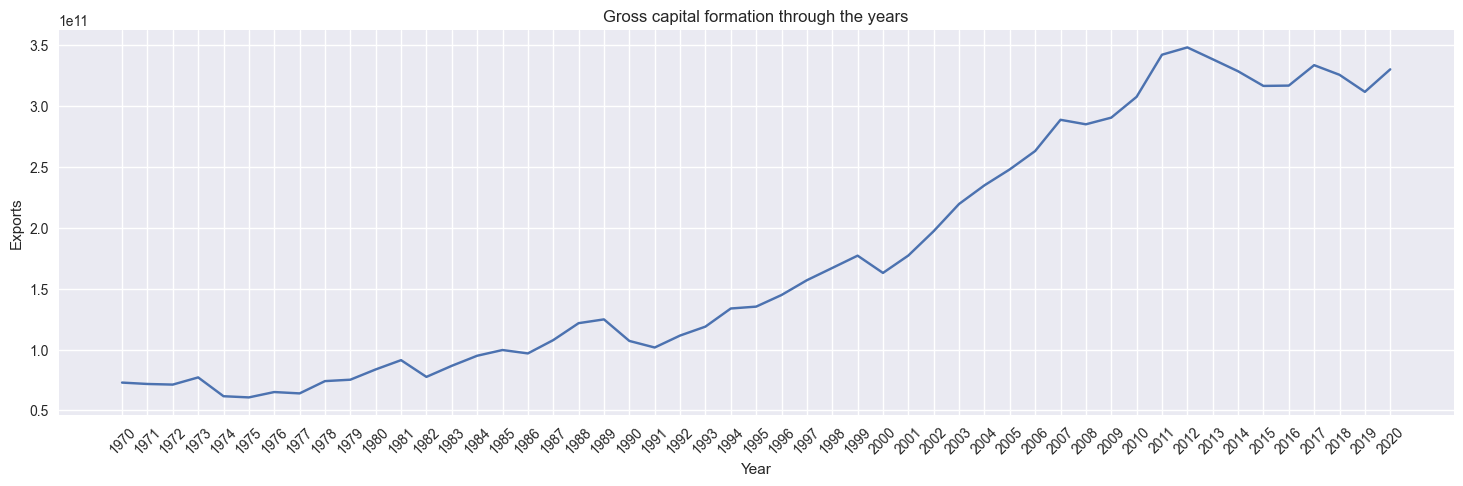

In [63]:
plt.figure(figsize=(18,5))
sns.lineplot(data=Australia_df, x="Year",y="Gross capital formation")
plt.ylabel("Exports")
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.title("Gross capital formation through the years")

Gross capital formation consists of outlays on additions to the fixed assets of the economy plus net changes in the level of inventories.
- The '80s and '90s : Economic expansion with increases in public and private investment through structural reforms.
- Beginning of the 2000s : Commodity boom driven by Chinese demand, with significant investments in the mining and natural resources sectors.
- Global financial crisis of 2008-2009 : Temporary decline in GCF, but Australia remained resilient due to continued demand for raw materials and expansionary economic policies.
- After the financial crisis : Investment recovery, especially in the mining sector, followed by a gradual decrease from 2013-2014 with the end of the super-cycle of raw materials.
- Recent years : Stabilization of mining investments and increases in other sectors such as infrastructure, renewable energy and technology, supported by government economic stimulus policies.

<h5><b>Imports of goods and services</b></h5>

Text(0.5, 1.0, 'Imports through the years')

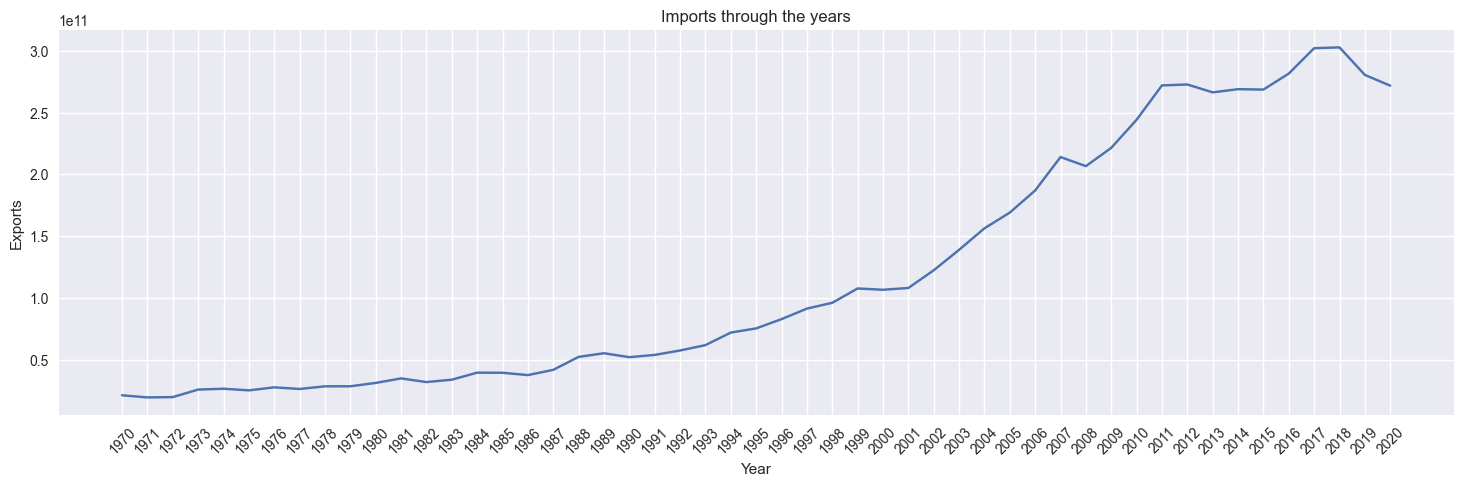

In [65]:
plt.figure(figsize=(18,5))
sns.lineplot(data=Australia_df, x="Year",y="Imports of goods and services")
plt.ylabel("Exports")
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.title("Imports through the years")